# Stochastic Series Expansion (SSE)

## 1. Theory

Algorithm based on the introduction by [Sandvik A.](https://physics.bu.edu/~sandvik/programs/ssebasic/ssebasic.html)

1. Representation of the 2 + 1 dimensional system (periodic)

In [52]:
Lx=4
Ly=2
Nsites = Lx*Ly
configuration = reshape([(i-0.5)/abs(i-0.5) for i in rand(Nsites)],Lx,Ly)
configuration

4×2 Array{Float64,2}:
  1.0   1.0
 -1.0   1.0
  1.0   1.0
 -1.0  -1.0

### a.) Bipartite lattice

The lattice must be representable as a bipartite lattice:

$$
\hat{H} = J \hat{S}_a\cdot\hat{S}_b
$$

Where $\textbf{a}$ and $\textbf{b}$ are the two sublattices.

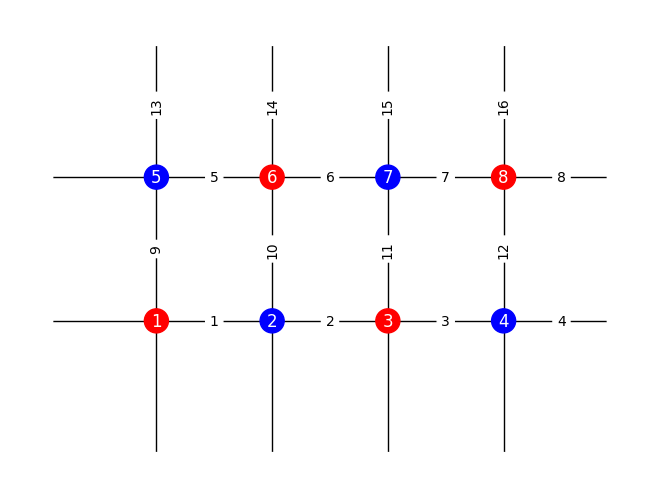

In [53]:
using ImageView, Images, TestImages
using PyPlot
using PyCall
using Conda


mplt = pyimport("matplotlib.pyplot")

nx = pyimport("networkx")

np = pyimport("numpy")

n=Lx+2
m=Ly+2

G = nx.grid_2d_graph(n,m)  # Lx, Ly grid

pos = Dict( (n, n) for n in G.nodes() );
#labels = Dict( ((i, j), i + (Ly-j) * (Lx+1) ) for (i,j) in G.nodes() );
#edges=Dict()
#for (i,edge) in enumerate(G.edges)
#    edges[edge]=i
#    print(i,"\t",edge,"\n")
#end


for j in 0:m-2
    G.remove_edge((0,j),(0,j+1))
    G.remove_edge((n-1,j),(n-1,j+1))
end
for i in 0:n-2
    G.remove_edge((i,0),(i+1,0))
    G.remove_edge((i,m-1),(i+1,m-1))
end


edgescenter = Dict()
countedge = 1
for j in 1:m-2
    for i in 1:n-2
        edgescenter[((i,j),(i+1,j))] = countedge
        countedge += 1
    end
end
for j in 1:m-2
    for i in 1:n-2
        edgescenter[((i,j),(i,j+1))] = countedge
        countedge += 1
    end
end

labelscenter = Dict()
countlabels = 1
for j in 1:m-2
    for i in 1:n-2
        labelscenter[(i,j)]=countlabels
        countlabels+=1
    end
end


color_map=[]
countcolor=0
for i in 0:n-1
    for j in 0:m-1
        if i==0 || j==0 || i==n-1 || j==m-1
            push!(color_map,"white")
        else
            if(countcolor%2 == 0)
                push!(color_map,"blue")
            else
                push!(color_map,"red")
            end
            countcolor+=1
        end
    end
    countcolor+=1
end

nx.draw(G, pos=pos, labels=labelscenter, node_color=color_map, font_color="white");
nx.draw_networkx_edge_labels(G,pos,edge_labels=edgescenter,font_color="black");



### b.) spin and opstring

spin[i] is the spin at the ith site and is of dim $Lx * Ly$.

opstring[i] is the operator string at order i. The dimension of opstring is the total number of operators M.


In [158]:
spin = configuration
spin = 1.0*[1; 1; -1; -1; 1; -1; 1; -1]

8-element Array{Float64,1}:
  1.0
  1.0
 -1.0
 -1.0
  1.0
 -1.0
  1.0
 -1.0

the opstring is a function of the type of operator $a$ and the bond id $b$ which is given by:

$$
opstring[p] = 2*b[p] + a[p] - 1
$$

with the condition that when a == b == 0 opstring = 0

In [154]:
MaxM = 12

a = zeros(MaxM)
a[1]=1
a[3]=2
a[4]=2
a[5]=1
a[8]=1
a[9]=2
a[11]=2
a[12]=1
b = zeros(MaxM)
b[1]=2
b[3]=4
b[4]=6
b[5]=3
b[8]=2
b[9]=6
b[11]=4
b[12]=7
opstring = zeros(MaxM)

function buildOpstring!(opstring,a,b)
    dim = length(a);
    eye = ones(dim);
    idxa = a .== 0;
    idxb = b .== 0;
    eye[idxa] .= 0;
    opstring .= 2 * b + a - eye;
end

buildOpstring!(opstring,a,b)
opstring

12-element Array{Float64,1}:
  4.0
  0.0
  9.0
 13.0
  6.0
  0.0
  0.0
  4.0
 13.0
  0.0
  9.0
 14.0

### c.) applying opstring

Apply opstring and evolve string in the imaginary time axis.

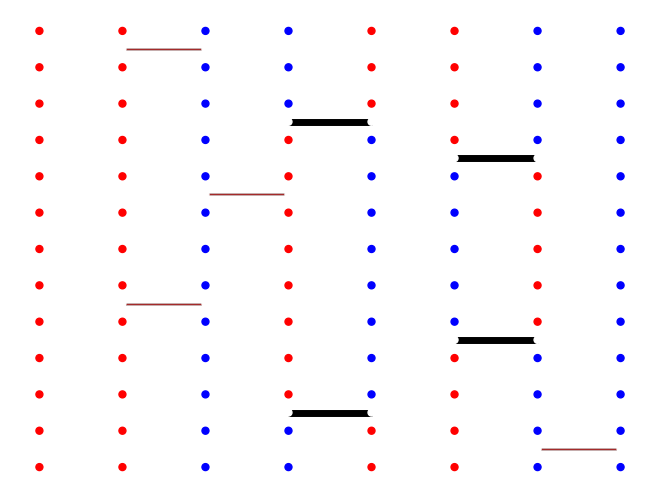

    1.0      1.0      -1.0      -1.0      1.0      1.0      -1.0      -1.0      

In [223]:
# draw the given opstring

using ImageView, Images, TestImages
using PyPlot
using PyCall
using Conda


mplt = pyimport("matplotlib.pyplot")

nx = pyimport("networkx")

np = pyimport("numpy")

m=2MaxM + 1
n=4*2

G = nx.grid_2d_graph(n,m)  # Lx, Ly grid
pos = Dict( (n, n) for n in G.nodes() );

color_map=[]
countcolor=1
for i in 0:n-1
    for j in 0:m-1
        if countcolor%2 == 0
            push!(color_map,"white")
        else
            push!(color_map,"blue")
        end
        countcolor+=1
    end
    countcolor+=1
end

for j in 0:m-2
    for i in 0:n-2
        G.remove_edge((i,j),(i+1,j))
        G.remove_edge((i,j),(i,j+1))
    end
    G.remove_edge((n-1,j),(n-1,j+1))
end
for i in 0:n-2
    G.remove_edge((i,m-1),(i+1,m-1))
end

# make the ops by looping over the imaginary time axis
# use a for the time direction and b for the space dimension
#G.add_edge((0,m-2),(1,m-2))
width=[]
edge_color=[]
for i in 1:MaxM
    if a[i] != 0
        J = m-2*i
        I = trunc(Int,b[i]-1)
        if a[i]==1
            G.add_edge((I,J),(I+1,J))
            push!(width,1.0)
            push!(edge_color,"brown")
        else
            G.add_edge((I,J),(I+1,J))
            push!(width,5.0)
            push!(edge_color,"black")
        end
    end
end


edges=[]
edge_color=[]
width=[]
for (i,edge) in enumerate(G.edges)
#    edges[edge]=i
    push!(edges,edge)
    J = edge[2][1]
    I = trunc(Int,MaxM-(edge[2][2]-1)/2)
    if a[I]==2
        push!(width,5.0)
        push!(edge_color,"black")
    else
        push!(width,1.0)
        push!(edge_color,"brown")
    end
end

for j in 1:MaxM    
    J = m-2*(j-1)        
    for i in 0:n-1
        I=i
#        print(J," ",I,"\t",J*(m-1)+I,"\n")
        if spin[i+1] == 1
            color_map[I*(m) + J] = "red"
        else
            color_map[i*(m) + J] = "blue"
        end
    end
    if a[j]==2
        for i in 0:n-1
            if b[j]==i+1
                spin[i+1]*=-1
                spin[i+2]*=-1
            end
        end 
    end
end
for i in 0:n-1
        J=m-2*(MaxM)
        I=i
        if spin[i+1] == 1
            color_map[I*(m) + J] = "red"
        else
            color_map[i*(m) + J] = "blue"
        end
 end

print("    ")
for i in 1:Lx*Ly
    print(spin[i],"      ")
end

nx.draw(G,pos,node_color=color_map, font_color="white",node_size=25)
nx.draw_networkx_edges(G,pos,edgelist=edges,width=width,edge_color=edge_color);


### d.) Vertex List I

The vertex list is a matrix of dimension (MaxM, 4) and contains the connections of the opstring and the spins.

The main algorithm to make the loops is the four index single opstring as shown below:

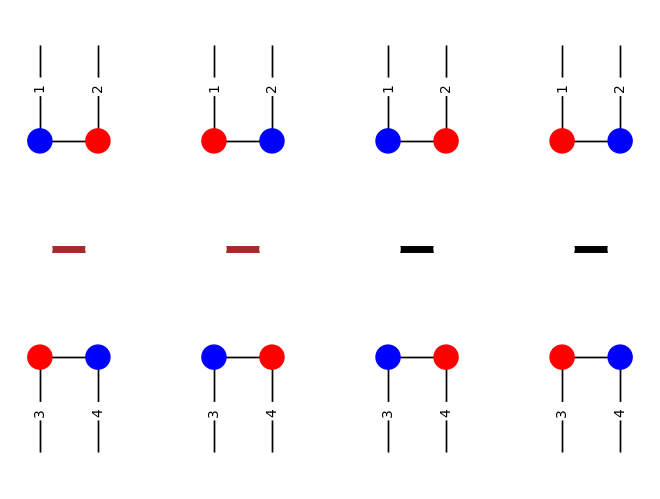

In [318]:
Gsmall = nx.grid_2d_graph(11,5)
pos = Dict( (n, n) for n in Gsmall.nodes() );

spinup = [1; -1; 0; -1; 1; 0; 1; -1; 0; -1; 1]
spindn = [1; -1; 0; -1; 1; 0; -1; 1; 0; 1; -1]
color_map=[]
countcolor=0
for i in 0:11-1
    for j in 0:5-1
        if (i+1) % 3 == 0
            push!(color_map,"white")
        else
            if (j+1) % 2 == 0
                if j == 1
                    if spindn[i+1] == -1
                        push!(color_map,"blue")
                    else
                        push!(color_map,"red")
                    end
                elseif j == 3
                    if spinup[i+1] == -1
                        push!(color_map,"red")
                    else
                        push!(color_map,"blue")
                    end
                else
                    push!(color_map,"white")
                end
            else
                push!(color_map,"white")
            end
        end
    end
    countcolor+=1
end

for i in 0:11-2
    Gsmall.remove_edge((i,0),(i+1,0))
    Gsmall.remove_edge((i,4),(i+1,4))
    Gsmall.remove_edge((i,2),(i+1,2))
    if (i)%3 == 1
        Gsmall.remove_edge((i,1),(i+1,1))
        Gsmall.remove_edge((i+1,1),(i+2,1))
        Gsmall.remove_edge((i,3),(i+1,3))
        Gsmall.remove_edge((i+1,3),(i+2,3))
    end
end
for j in 0:5-2
    for i in 0:11-1
        if j == 0 || j == 5 - 2
            if (i+1) % 3 == 0
                Gsmall.remove_edge((i,j),(i,j+1))
            end
        else
            Gsmall.remove_edge((i,j),(i,j+1))
        end
    end
end

for i in 0:11-2
    if (i+1)%3 == 1
        Gsmall.add_edge((i,2),(i+1,2),width=5.0)
    end
end

edges=[]
edge_color=[]
width=[]
for (i,edge) in enumerate(Gsmall.edges)
#    edges[edge]=i
    push!(edges,edge)
    J = edge[2][1]
    I = edge[2][2]
    if I == 2
        if J <= 4
            push!(width,5.0)
            push!(edge_color,"brown")
        else
            push!(width,5.0)
            push!(edge_color,"black")
        end
    else
        push!(width,1.0)
        push!(edge_color,"black")
    end
end

edgelabels = Dict()
for j in 0:11-2
    if (j+1)%3==1
        edgelabels[((j,0),(j,1))] = 3
        edgelabels[((j+1,0),(j+1,1))] = 4
        edgelabels[((j,3),(j,4))] = 1
        edgelabels[((j+1,3),(j+1,4))] = 2
    end
end


nx.draw(Gsmall, pos=pos, node_color=color_map)
nx.draw_networkx_edges(Gsmall,pos,edgelist=edges,width=width,edge_color=edge_color);
nx.draw_networkx_edge_labels(Gsmall,pos,edge_labels=edgelabels);


### e.) Vertex List II

now to actually make the vertex list. Maybe a recursive algorithm can work !?

$$
vertexlist[v] = 4*(p-1) + l(p)
$$

where l(p) is the leg ind

$$
l(p) = 1,2,3,4
$$

In [603]:
# find the number of operators
# and their locations
op_ids = findall(x->x > 0,a)
print("Ids     =","\t",op_ids,"\n")
num_op = size(op_ids)[1]

# get bond corresponding to each operator
bond_op = b[op_ids]
print("bond Id =","\t",bond_op,"\n")

# get bond type
bond_type = a[op_ids]
print("bond Type=","\t",bond_type,"\n")

# make bond list which holds the ids of the ops
# which act on the same bond before and after the
# current op id
same_bond_list = zeros(num_op,4)
for i in 1:num_op
    bid = bond_op[i]
    idlist_same_bids = findall(x->x==bid,bond_op)
    num_same_bid = size(idlist_same_bids)[1]
    idcurrent = findall(x->x==i,idlist_same_bids)[1]
#    print(i,"\t",idlist_same_bids,"\t",idcurrent)
    if num_same_bid > 1
        if idcurrent > 1 && idcurrent < num_same_bid
#            print("\t,","prev=",idlist_same_bids[idcurrent-1],"\t next=",idlist_same_bids[idcurrent+1],"\n")
            same_bond_list[i,2] = idlist_same_bids[idcurrent-1]
            same_bond_list[i,1] = i
            same_bond_list[i,3] = idlist_same_bids[idcurrent+1]
            same_bond_list[i,4] = 2
        elseif idcurrent == 1
#            print("\t","next=",idlist_same_bids[idcurrent+1],"\n")
            same_bond_list[i,1] = 3
            same_bond_list[i,3] = idlist_same_bids[idcurrent+1]
            same_bond_list[i,4] = 1
        elseif idcurrent == num_same_bid
#            print("\t","prev=",idlist_same_bids[idcurrent-1],"\n")
            same_bond_list[i,2] = idlist_same_bids[idcurrent-1]
            same_bond_list[i,1] = 2
            same_bond_list[i,4] = 1
        end
    else
#        print("\n")
    end
end
#printmat(same_bond_list)

# make the list of op ids which act on bond ids
# one before and one after the current bond id
# e.g.
# -a-
#   |
#   |    -b-
#   |    |
#   1    2
#    ----
#   3    4
#   |    |
# -c-    |
#         -d-
#
# the stored indices will be [1,2,4,5] each for the
# four legs
print("\n")
diff_bond_list = zeros(num_op,4)
for i in 1:num_op
    bid = bond_op[i]
    if bid > 1 && bid < num_op
        # first do the prev bond
        idlist_prev_bid = findall(x->x==(bid-1),bond_op)
        num_prev_bid = size(idlist_prev_bid)[1]
        
#        print("prev=",idlist_prev_bid,"\t")
        
        if num_prev_bid > 0
            # get the ids which are adjascent to the
            # current id
            ids_adjascent_prev = [searchsortedlast(idlist_prev_bid,i),searchsortedfirst(idlist_prev_bid,i)]
#            print("Lsearch Ids=",ids_adjascent_prev,"\t")
            diag_up = trunc(Int,same_bond_list[i,2])
            diag_dn = trunc(Int,same_bond_list[i,3])
            if ids_adjascent_prev[1] > 0 && ids_adjascent_prev[2] < 2 + 1               
                ids_adjascent_prev = ids_adjascent_prev[findall(x->x>0,ids_adjascent_prev)]
                ids_adjascent_prev = ids_adjascent_prev[findall(x->x<num_prev_bid+1,ids_adjascent_prev)]
                num_prev_bid = size(ids_adjascent_prev)[1]
                winded_bond = false
            elseif ids_adjascent_prev[1] == 0
                if diag_dn > idlist_prev_bid[1] || diag_dn == 0
                    ids_adjascent_prev = ids_adjascent_prev[findall(x->x>0,ids_adjascent_prev)]
                    ids_adjascent_prev = ids_adjascent_prev[findall(x->x<num_prev_bid+1,ids_adjascent_prev)]
                    num_prev_bid = size(ids_adjascent_prev)[1]
                    winded_bond = false                    
                else
                    # if there are no diagonal terms above this then we take the 
                    # last one on the next list
                    if same_bond_list[i,2] == 0.0
                        ids_adjascent_prev = [size(idlist_prev_bid)[1]]
                        num_prev_bid = 1
                        winded_bond = true
                    else
                        ids_adjascent_prev = []
                        num_next_bid = 0
                    end                    
                end
            elseif ids_adjascent_prev[2] == 2 + 1
                if diag_up < idlist_prev_bid[end]
#                    print("L cond 3 ","\t")
                    ids_adjascent_prev = ids_adjascent_prev[findall(x->x>0,ids_adjascent_prev)]
                    ids_adjascent_prev = ids_adjascent_prev[findall(x->x<num_prev_bid+1,ids_adjascent_prev)]
                    num_prev_bid = size(ids_adjascent_prev)[1]
                    winded_bond = false 
                    if diag_dn == 0 && diag_up == 0
                        p_dn = op_ids[idlist_prev_bid[1]]
                        diff_bond_list[i,3] = 4*(p_dn - 1) + 2
                    end
                else
                    # if there are no diagonal terms below then 
                    # the winded leg attaches to the first of the next bid
                    if same_bond_list[i,3] == 0.0
                        ids_adjascent_prev = [1]
                        num_next_bid = 1
                        winded_bond = true
                    else
                        ids_adjascent_prev = []
                        num_next_bid = 0
                    end                    
                end
            end
        end
        
        # next do the next bond
        idlist_next_bid = findall(x->x==(bid+1),bond_op)
        num_next_bid = size(idlist_next_bid)[1]
        
#        print("next=",idlist_next_bid,"\t")
        
        if num_next_bid > 0
            ids_adjascent_next = [searchsortedlast(idlist_next_bid,i),searchsortedfirst(idlist_next_bid,i)]
#            print("Rsearch Ids=",ids_adjascent_next,"\t")
            diag_up = trunc(Int,same_bond_list[i,2])
            diag_dn = trunc(Int,same_bond_list[i,3])
#            print("up dn ",diag_up," ",diag_dn,"\t")
            if ids_adjascent_next[1] > 0 && ids_adjascent_next[2] < 2 + 1 
                # found two 
#                print(ids_adjascent_next,"\t")
                ids_adjascent_next = ids_adjascent_next[findall(x->x>0,ids_adjascent_next)]
                ids_adjascent_next = ids_adjascent_next[findall(x->x<num_next_bid+1,ids_adjascent_next)]
                num_next_bid = size(ids_adjascent_next)[1]
                winded_bond = false
            elseif ids_adjascent_next[1] == 0
                if diag_dn > idlist_next_bid[1] || diag_dn == 0
                    ids_adjascent_next = ids_adjascent_next[findall(x->x>0,ids_adjascent_next)]
                    ids_adjascent_next = ids_adjascent_next[findall(x->x<num_next_bid+1,ids_adjascent_next)]
                    num_next_bid = size(ids_adjascent_next)[1]
                    winded_bond = false                     
                else
                    # if there are no diagonal terms above this then we take the 
                    # last one on the next list
                    if same_bond_list[i,2] == 0.0
                        ids_adjascent_next = [size(idlist_next_bid)[1]]
                        num_next_bid = 1
                        winded_bond = true
                    else
                        ids_adjascent_next = []
                        num_next_bid = 0
                    end
                end
            elseif ids_adjascent_next[2] == 2 + 1
                if diag_up < idlist_next_bid[end]
                    ids_adjascent_next = ids_adjascent_next[findall(x->x>0,ids_adjascent_next)]
                    ids_adjascent_next = ids_adjascent_next[findall(x->x<num_next_bid+1,ids_adjascent_next)]
                    num_next_bid = size(ids_adjascent_next)[1]
                    winded_bond = false        
                    if diag_up == 0 && diag_dn == 0
                        p_dn = op_ids[idlist_next_bid[1]]
                        diff_bond_list[i,4] = 4*(p_dn - 1) + 1
                    end                     
                else
                    # if there are no diagonal terms below then 
                    # the winded leg attaches to the first of the next bid
                    if same_bond_list[i,3] == 0.0
                        ids_adjascent_next = [1]
                        num_next_bid = 1
                        winded_bond = true
                    else
                        ids_adjascent_next = []
                        num_next_bid = 0
                    end
                end
            end
        end   
        
#        print(i,"\t",idlist_next_bid,"\t",num_prev_bid," ",num_next_bid,"\n")

        if num_prev_bid == 1

        
            # now save the bond ids for the prev
            if winded_bond
                if idlist_prev_bid[ids_adjascent_prev[1]] > i
                    p_up = op_ids[idlist_prev_bid[ids_adjascent_prev[1]]]
                    diff_bond_list[i,1] = 4*(p_up - 1) + 4
                else
                    p_dn = op_ids[idlist_prev_bid[ids_adjascent_prev[1]]]
                    diff_bond_list[i,3] = 4*(p_dn - 1) + 2
                end                
            else                
                if idlist_prev_bid[ids_adjascent_prev[1]] > i
                    p_dn = op_ids[idlist_prev_bid[ids_adjascent_prev[1]]]
                    diff_bond_list[i,3] = 4*(p_dn - 1) + 2
                else
                    p_up = op_ids[idlist_prev_bid[ids_adjascent_prev[1]]]
                    diff_bond_list[i,1] = 4*(p_up - 1) + 4
                end
            end

            
        elseif num_prev_bid == 2
            
            # now save the bond ids for the next            
            p_up = op_ids[idlist_prev_bid[ids_adjascent_prev[1]]]
            diff_bond_list[i,1] = 4*(p_up - 1) + 4
            p_dn = op_ids[idlist_prev_bid[ids_adjascent_prev[2]]]
            diff_bond_list[i,3] = 4*(p_dn - 1) + 2

        end
        
        if num_next_bid == 1
            
            # now save the bond ids for the next
            if winded_bond
                if idlist_next_bid[ids_adjascent_next[1]] > i
                    p_up = op_ids[idlist_next_bid[ids_adjascent_next[1]]]
                    diff_bond_list[i,2] = 4*(p_up - 1) + 3
                else
                    p_dn = op_ids[idlist_next_bid[ids_adjascent_next[1]]]
                    diff_bond_list[i,4] = 4*(p_dn - 1) + 1
                end
            else
                if idlist_next_bid[ids_adjascent_next[1]] > i
                    p_dn = op_ids[idlist_next_bid[ids_adjascent_next[1]]]
                    diff_bond_list[i,4] = 4*(p_dn - 1) + 1
                else
                    p_up = op_ids[idlist_next_bid[ids_adjascent_next[1]]]
                    diff_bond_list[i,2] = 4*(p_up - 1) + 3
                end
            end


        elseif num_next_bid == 2
        
            # now save the bond ids for the next
            p_up = op_ids[idlist_next_bid[ids_adjascent_next[1]]]
            diff_bond_list[i,2] = 4*(p_up - 1) + 3
            p_dn = op_ids[idlist_next_bid[ids_adjascent_next[2]]]
            diff_bond_list[i,4] = 4*(p_dn - 1) + 1

        end
 
    elseif bid == 1
        
    elseif bid == num_op
    end
end
#printmat(diff_bond_list)

# Now append the list with the diagonal terms
# fill up the missing index connections
print("\n")
for i in 1:num_op
    id_zeros = findall(x->x==0,diff_bond_list[i,1:end])
    id_op_ids = findall(x->x>0,diff_bond_list[i,1:end])
    num_zeros = size(id_zeros)[1]
    num_ops = size(id_op_ids)[1]
#    print("\n",i,"\t",num_zeros,"\t")
    if num_zeros > 0
        ndiag = trunc(Int,same_bond_list[i,4])
        pos = trunc(Int,same_bond_list[i,1])
#        print(ndiag,"\t pos=",pos,"\t")
        if ndiag==0
            # case of no diag ops
            opid = i
            
            # 1 diag op below => pos == 2
            # 1 diag op above => pos == 3
            if diff_bond_list[i,1] == 0
                p_up = op_ids[opid]
                diff_bond_list[i,1] = 4*(p_up - 1) + 3
            end
            if diff_bond_list[i,2] == 0
                p_up = op_ids[opid]
                diff_bond_list[i,2] = 4*(p_up - 1) + 4
            end
            if diff_bond_list[i,3] == 0
                p_dn = op_ids[opid]
                diff_bond_list[i,3] = 4*(p_dn - 1) + 1
            end
            if diff_bond_list[i,4] == 0
                p_dn = op_ids[opid]
                diff_bond_list[i,4] = 4*(p_dn - 1) + 2
            end 

        elseif ndiag==1
            # case of 1 diag op
            opid = trunc(Int,same_bond_list[i,pos])
            
            # 1 diag op below => pos == 2
            # 1 diag op above => pos == 3
            if diff_bond_list[i,1] == 0
                p_up = op_ids[opid]
                diff_bond_list[i,1] = 4*(p_up - 1) + 3
            end
            if diff_bond_list[i,2] == 0
                p_up = op_ids[opid]
                diff_bond_list[i,2] = 4*(p_up - 1) + 4
            end
            if diff_bond_list[i,3] == 0
                p_dn = op_ids[opid]
                diff_bond_list[i,3] = 4*(p_dn - 1) + 1
            end
            if diff_bond_list[i,4] == 0
                p_dn = op_ids[opid]
                diff_bond_list[i,4] = 4*(p_dn - 1) + 2
            end  
        
        elseif ndiag==2
            # case of 2 diag op
#            print(" 2diag ")
            opid_dn = trunc(Int,same_bond_list[i,2])
            opid_up = trunc(Int,same_bond_list[i,3])
            if diff_bond_list[i,1] == 0
                p_up = op_ids[opid_up]
                diff_bond_list[i,1] = 4*(p_up - 1) + 3
            end
            if diff_bond_list[i,2] == 0
                p_up = op_ids[opid_up]
                diff_bond_list[i,2] = 4*(p_up - 1) + 4
            end
            if diff_bond_list[i,3] == 0
                p_dn = op_ids[opid_dn]
                diff_bond_list[i,3] = 4*(p_dn - 1) + 1
            end
            if diff_bond_list[i,4] == 0
                p_dn = op_ids[opid_dn]
                diff_bond_list[i,4] = 4*(p_dn - 1) + 2
            end
        end
end
end
#printmat(diff_bond_list)

# finally make vertexlist
vertexlist = zeros(MaxM,4)
j=0
for i in 1:MaxM
    if a[i] > 0
        j += 1
        vertexlist[i,:] = diff_bond_list[j,:]
    end
end

for i in 1:MaxM
    for j in 1:4
        print("[",4*(i-1) + j,"]","\t",vertexlist[i,j],"\t")
    end
    print("\n")
end

Ids     =	[1, 3, 4, 5, 8, 9, 11, 12]
bond Id =	[2.0, 4.0, 6.0, 3.0, 2.0, 6.0, 4.0, 7.0]
bond Type=	[1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0]


[1]	31.0	[2]	32.0	[3]	29.0	[4]	17.0	
[5]	0.0	[6]	0.0	[7]	0.0	[8]	0.0	
[9]	43.0	[10]	44.0	[11]	18.0	[12]	42.0	
[13]	35.0	[14]	47.0	[15]	33.0	[16]	34.0	
[17]	4.0	[18]	11.0	[19]	30.0	[20]	41.0	
[21]	0.0	[22]	0.0	[23]	0.0	[24]	0.0	
[25]	0.0	[26]	0.0	[27]	0.0	[28]	0.0	
[29]	3.0	[30]	19.0	[31]	1.0	[32]	2.0	
[33]	15.0	[34]	16.0	[35]	13.0	[36]	45.0	
[37]	0.0	[38]	0.0	[39]	0.0	[40]	0.0	
[41]	20.0	[42]	12.0	[43]	9.0	[44]	10.0	
[45]	36.0	[46]	48.0	[47]	14.0	[48]	46.0	


### f.) Construct loop

In [704]:
# construct a loop by traversing the vertexlist.
# The rule is simply to follow the two steps:
#     1. start by picking an element of vertexlist(p)
#     2. go to the index pointed to by p
#     3. if l(p) == 1 move to 2 or if l(p) == 2 move to 1 and similarly for 3,4
#     4. go to vertexlist(p') and continue from step 1

move = Dict()
move[1]=2
move[2]=1
move[3]=4
move[4]=3

lpmove = Dict()
lpmove[0]=4
lpmove[1]=1
lpmove[2]=2
lpmove[3]=3
pstart = 1
lpstart = 4
p = 1
lp = 4
q = 0
v=0
loopids = []
push!(loopids,p)
count = 1
while q != pstart && count < 10
    v = vertexlist[p,lp]
    lp = lpmove[trunc(Int,v%4)]
    p = trunc(Int,1 + (v-lp)/4)
#    print(">",p,"\t",lp,"\t",v,"\n")
    lp = move[lp]
    q = p
    lq = lp
    count += 1
#    print(count,"\t",p,"\t",lp,"\t v=",4*(p-1)+lp,"\n")
    push!(loopids,p)
end
printmat(loopids)
print("\n")
op_ids[mapfoldl(x->op_ids.!=x,(x,y)->x.*y,loopids)]


7-element Array{Any,1}:
  1
  5
  3
 11
  5
  8
  1


3-element Array{Int64,1}:
  4
  9
 12

-----------------------------------------------

# Testing and Helpers

## Print Mat

In [509]:
function printmat(mat)
    print("\n")
    show(Base.stdout, MIME"text/plain"(),mat)
end

printmat (generic function with 1 method)

## Other

In [693]:
tmparray=[1; 2; 3]
findall(x->x==3,tmparray)

1-element Array{Int64,1}:
 3

In [524]:
tmparray = zeros(10)
ids = [1; 2; 3]
tmparray[ids] .= 2
tmparray

10-element Array{Float64,1}:
 2.0
 2.0
 2.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [656]:
tmpvec = [1; 2; 3; 4;]
size(tmpvec[tmpvec.==4])

(1,)

In [467]:
tmparray = [2]
print(tmparray)
tmparray=tmparray[findall(x->x<4,tmparray)]
print(tmparray)

[2][2]

In [540]:
using Base.Iterators: flatten
tmparray = [11.; 12.; 13.; 14.; 15.; 16.; 17.; 18.; 19.]
print(size(tmparray),"\n")
print(searchsortedfirst(tmparray,24.5),"\n")
print(searchsortedlast(tmparray,24.5))

(9,)
10
9

In [125]:
macro assert(ex)
           return :( $ex ? nothing : throw(AssertionError($(string(ex)))) )
end

eye=ones(10)
zer=zeros(10)
@assert eye == zer

AssertionError: AssertionError: eye == zer

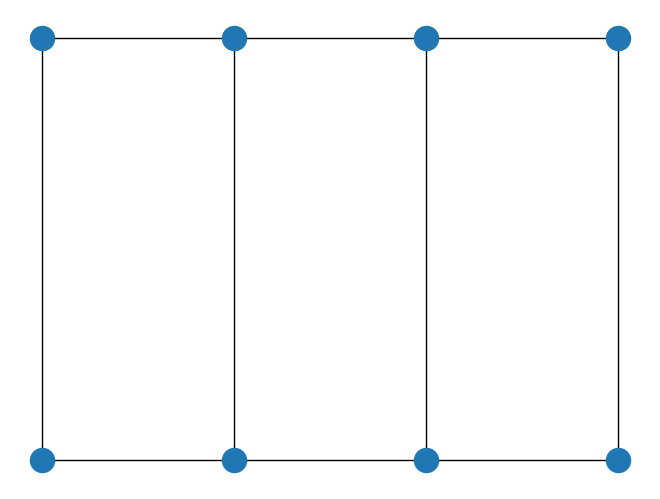

In [44]:

using ImageView, Images, TestImages

mplt = pyimport("matplotlib.pyplot")

nx = pyimport("networkx")

widget = pyimport("ipywidgets")

G = nx.grid_2d_graph(Lx, Ly)  # 5x5 grid
pos = Dict( (n, n) for n in G.nodes() )
nx.draw(G, pos=pos)




In [20]:

function random_lobster(n, m, k, p)
    return nx.random_lobster(n, p, p / m)
end

function powerlaw_cluster(n, m, k, p)
    return nx.powerlaw_cluster_graph(n, m, p)
end

function erdos_renyi(n, m, k, p)
    return nx.erdos_renyi_graph(n, p)
end

function newman_watts_strogatz(n, m, k, p)
    return nx.newman_watts_strogatz_graph(n, k, p)
end

function plot_random_graph(n, m, k, p)
    g = powerlaw_cluster(n, m, k, p)
    nx.draw(g)
    mplt.show()
end

widget.interact(plot_random_graph, n=(2,30), m=(1,10), k=(1,10), p=(0.0, 1.0, 0.001))

PyObject <function _InteractFactory.__call__.<locals>.<lambda> at 0x14c8cabf8>

#### Using Graphviz

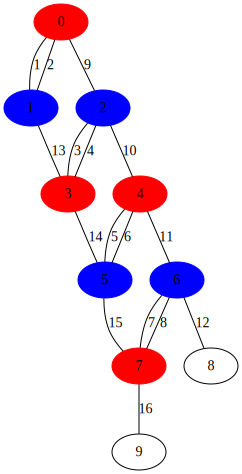

In [16]:
using PyPlot
using PyCall
using Conda


graphviz = pyimport("graphviz");

dot = graphviz.Graph()

# Add nodes 1 and 2
countline = 0
for ndeI in 0:Lx-1
    for ndeJ in 0:Ly-1
        if (ndeI*Ly + ndeJ + countline)%2 == 0
            dot.node(string(ndeI*Ly + ndeJ),style="filled",color="red")
        else
            dot.node(string(ndeI*Ly + ndeJ),style="filled",color="blue")
        end
    end
    countline += 1
end


# Add edge between 1 and 2
countedge = 1
for ndeI in 0:Lx-1
    for ndeJ in 0:Ly-1
        if ndeJ < Ly-1
            dot.edge(string(ndeI*Ly + ndeJ),string(ndeI*Ly + ndeJ+1),label=string(countedge))
        else
            dot.edge(string(ndeI*Ly + 0),string(ndeI*Ly + ndeJ),label=string(countedge))
        end
        countedge += 1
    end
end

for ndeJ in 0:Ly-1
    for ndeI in 0:Lx-1
#        if ndeI < Lx-1
            dot.edge(string(ndeI*Ly + ndeJ),string((ndeI+1)*Ly + ndeJ),label=string(countedge))
#        else
#            dot.edge(string(0*Ly + ndeJ),string((ndeI)*Ly + ndeJ),label=string(countedge))
#        end
            countedge += 1
    end
end


dot

In [400]:
tmpvec = [1; 4; 3; 4; 5;]
findall(x->x==4,tmpvec)

2-element Array{Int64,1}:
 2
 4